# Movie Data ERD diagram

![Movie Data ERD](./movie_data_erd.jpeg)

# 1. Trend analysis for runtimes and popularity

- Movie runtime is the length of time a movie takes to run to the end this is typically measured in minutes.
- Analyzing trends in runtime and popularity of movies over the years can reveal a lot about how the film industry—and audience preferences—have evolved

# 2. Objectives for this section

- To understand how the runtime trends has changed over time
- To evaluate whether there is a correlation between runtime, average ratings and the popularity of a film. 

# 3. Approach
- Find the data with average runtime, popularity attributes of a film
- Consolidate the relevant columns for analysis into one dataset
- Clean the data by checking for inconsistencies and null values
- Developing a hypothesis test

*First import the necessary libraries*

In [51]:
# import the necessary libraries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib as plt
from scipy.stats import linregress, t, ttest_ind



In [52]:
# Loading the dataset
conn = sqlite3.connect('im.db')

*Checking the querying the database to confirm that it contains tables similar to the ERD*

In [53]:
print(f"The database has the following list of table:\n",'=' * 50,'\n') 
table_df  = pd.read_sql("PRAGMA table_list",conn).loc[:,'name']
print(table_df)


The database has the following list of table:

0               writers
1            principals
2               persons
3         movie_ratings
4            movie_akas
5             known_for
6             directors
7          movie_basics
8         sqlite_schema
9    sqlite_temp_schema
Name: name, dtype: object


The tables match the ones on the ERD
We now need to select the columns that we will need  inorder to perform the analysis.
## Criteria for selection
- we chose the movie_ratings table because it contains the average ratings of the movies. 
- We chose the movie basics table because it has the runtimes in minutes and the year of screening which will help us  get the correlation and the of runtime with popularity.
- we chose the tmdb dataset because it as a popularity column within it.

In [54]:
# joining the ratings and the basics dataset

print("Here we joined the two tables: movie ratings and movie basics")
q = """
SELECT * 
FROM movie_ratings 
JOIN movie_basics
USING(movie_id);
"""
basics = pd.read_sql(q,conn)

# read in the tmdb dataset to be able to get the popularity

tmdb = pd.read_csv('./zippedData/tmdb.movies.csv')
tmdb.head()

Here we joined the two tables: movie ratings and movie basics


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


# Merge the dataset together before cleaning


In [55]:
# Create a combined string for matching
basics['title_match'] = basics['primary_title'].str.lower().str.strip()
tmdb['movies_title'] = tmdb['original_title'].str.lower().str.strip()

merge_df = pd.merge(basics, tmdb, left_on='title_match', right_on='movies_title', how='inner')
merge_df.head()

,movie_id,averagerating,numvotes,primary_title,original_title_x,start_year,runtime_minutes,genres,title_match,Unnamed: 0,genre_ids,id,original_language,original_title_y,popularity,release_date,title,vote_average,vote_count,movies_title
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",the legend of hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,The Legend of Hercules,4.5,805,the legend of hercules
1,tt1069246,6.2,326,Habana Eva,Habana Eva,2010,106.0,"Comedy,Romance",habana eva,1075,"[35, 10749]",55961,es,Habana Eva,1.400,2010-05-28,Habana Eva,7.0,4,habana eva
2,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,baggage claim,8084,[35],175528,en,Baggage Claim,8.666,2013-09-27,Baggage Claim,5.4,127,baggage claim
3,tt1174693,5.8,2381,The Four-Faced Liar,The Four-Faced Liar,2010,87.0,"Comedy,Drama,Romance",the four-faced liar,601,"[35, 18, 10749]",44991,en,The Four-Faced Liar,3.091,2010-01-01,The Four-Faced Liar,5.3,25,the four-faced liar
4,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",moneyball,2505,[18],60308,en,Moneyball,15.393,2011-09-22,Moneyball,7.1,2255,moneyball


## Select the columns we are going to use

From the combined dataset we will filter out only the columns we need for the analysis to make the analysis faster.

In [56]:
# Created a list of column names for the project

cols = ['movie_id','averagerating','title_match','start_year','runtime_minutes','genres','popularity','original_language']
merged_df = merge_df[cols]

# DATA CLEANING

### Identifying the null values

In [57]:
# There are very few null values across the dataset.
print("the columns have this kind of table distribution")
merged_df.isnull().sum()

the columns have this kind of table distribution


movie_id               0
averagerating          0
title_match            0
start_year             0
runtime_minutes      569
genres                71
popularity             0
original_language      0
dtype: int64

### We will remove the null values 

In [58]:

merged_df.loc[:,'runtime_minutes'] = merged_df['runtime_minutes'].fillna(merged_df["runtime_minutes"].mean())
merged_df = merged_df.dropna(subset = ['genres'])
merged_df.isnull().sum()

movie_id             0
averagerating        0
title_match          0
start_year           0
runtime_minutes      0
genres               0
popularity           0
original_language    0
dtype: int64

# What is the trend in runtimes over the years?

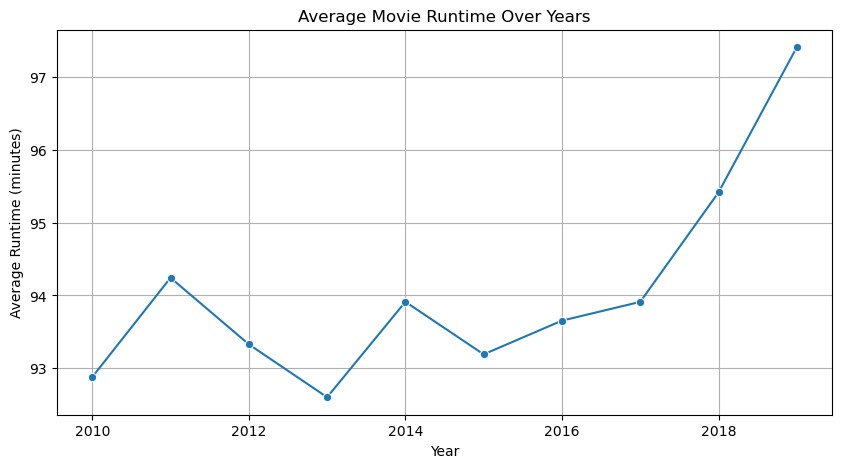

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group start_year and calculate mean runtime
runtime_trends = merged_df.groupby('start_year')['runtime_minutes'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x='start_year', y='runtime_minutes', data=runtime_trends, marker='o')
plt.title('Average Movie Runtime Over Years')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.grid(True)
plt.show()


### Distribution of runtime and Popularity and average ratings

We will check the distribution to see the shape of the data

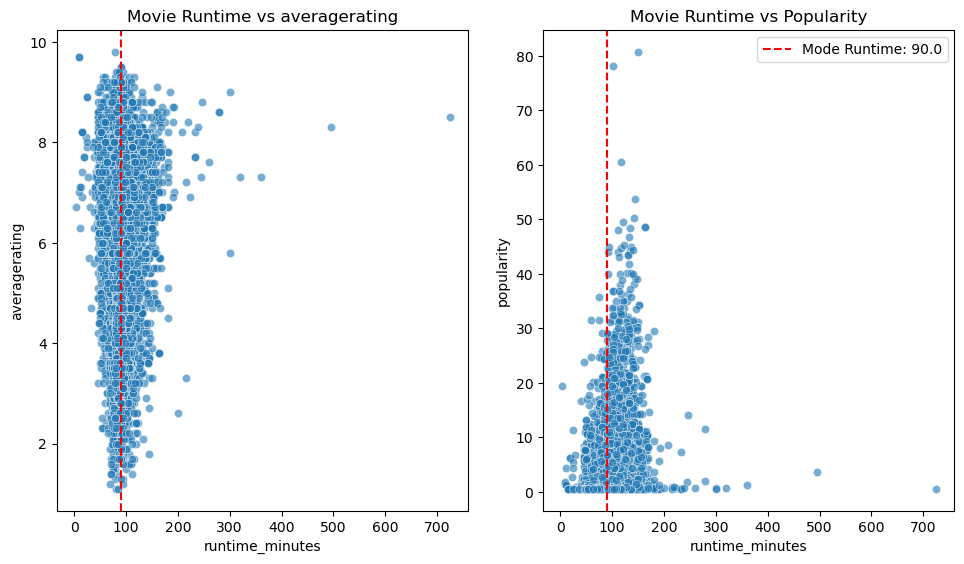

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

mode_runtime = merged_df['runtime_minutes'].mode()[0]  # Get the scalar mode value

fig, axes = plt.subplots(1,2, figsize=(10, 6))
sns.scatterplot(x='runtime_minutes', y='averagerating', data=merged_df, alpha=0.6,ax=axes[0])
sns.scatterplot(x='runtime_minutes', y='popularity', data=merged_df, alpha=0.6, ax=axes[1])

axes[0].axvline(x=mode_runtime, linestyle='--', color='r', label=f'Mode Runtime: {mode_runtime}')
axes[1].axvline(x=mode_runtime, linestyle='--', color='r', label=f'Mode Runtime: {mode_runtime}')

axes[0].set_title('Movie Runtime vs averagerating')
axes[1].set_title('Movie Runtime vs Popularity')
plt.tight_layout(pad=2)
plt.legend()
plt.show()


 #### Observations 
- The data has some outliers; that is movies with runtimes well above 240 minutes.
- We will need to remove or filter the outliers so as not to skew the mean or the standard deviation for hypothesis testing
- But overally most of the movies seem to be clustering near the 90 and 120 minute runtime
- The increase in runtime does not seem to influence either the popularity or the average ratings.
However we will need to prove this statistically.

## What is the correlation between popularity and average ratings of a film?

In [61]:
correlation = merged_df['popularity'].corr(merged_df['averagerating'])
print(f"Correlation between popularity and average rating: {correlation:.2f}")

correlation = merged_df['popularity'].corr(merged_df['runtime_minutes'])
print(f"Correlation between popularity and tuntime: {correlation:.2f}")

print("\nOBSERVATION\n")
print("="*50,"\n")
print("""
The analysis shows that there is a very weak relationship between a
      movie’s popularity and its average rating, and only a weak relationship
       between popularity and runtime. This means that more popular movies are
      not necessarily rated higher, and while longer movies may be slightly 
      more popular, runtime alone does not strongly determine popularity. 
      Other factors are likely more important in making a movie popular.
""")

Correlation between popularity and average rating: 0.12
Correlation between popularity and tuntime: 0.29

OBSERVATION



The analysis shows that there is a very weak relationship between a
      movie’s popularity and its average rating, and only a weak relationship
       between popularity and runtime. This means that more popular movies are
      not necessarily rated higher, and while longer movies may be slightly 
      more popular, runtime alone does not strongly determine popularity. 
      Other factors are likely more important in making a movie popular.



We conducted a hypothesis test to validate the above findings.
We used a ttest and measured the critical values

## Hypothesis testing
🎯 *Hypothesis Testing — Does Runtime Affect Popularity and Ratings?*

    a) For Popularity:
    Null Hypothesis (H₀): Runtime has no effect on popularity. (H₀: μ₁ = μ₂)

    Alternative Hypothesis (H₁): Runtime has an effect on popularity. (H₁: μ₁ ≠ μ₂)

    b) For Average Rating:
    Null Hypothesis (H₀): Runtime has no effect on average rating. (H₀: μ₁ = μ₂)

    Alternative Hypothesis (H₁): Runtime has an effect on average rating. (H₁: μ₁ ≠ μ₂)

### Subsetting the data

In [62]:
# slicing the dataset to just get the columns we will be working with
sliced_df = merged_df[['averagerating','runtime_minutes','popularity']]

### Filtering outliers

In [63]:
# Filter out extreme outliers (e.g., movies with runtime > 240 minutes)
filtered_df = sliced_df[sliced_df['runtime_minutes'] <= 240]
filtered_df

,averagerating,runtime_minutes,popularity
0,4.2,99.000000,13.754
1,6.2,106.000000,1.400
2,5.1,96.000000,8.666
3,5.8,87.000000,3.091
4,7.6,133.000000,15.393
...,...,...,...
18561,7.5,100.000000,0.600
18562,8.2,104.000000,0.600
18563,3.5,81.000000,2.709
18564,6.3,64.000000,0.600


### Conducting T-test

Inorder for us to test the hypothesis, we will use a ttest to find the t-values and the p-values necessary to either reject or fail to reject the Null hypoythesis. 
Since we have already set up our hypothesis which is the first step we will then proceed with the preceeding steps of:

- Choosing a significance level
- Calculate the test statistic (t-value)
- Determine the critical t-value (find the rejection region)
- Compare t-value with critical t-value to determine if we can reject the null hypothesis.

_We will begin by splitting the data into two groups and test for differences in mean popularity and average rating._


In [64]:
import numpy as np
from scipy.stats import ttest_ind

# STEP 1: Compute median runtime to split the movies into two different groups
median_runtime = filtered_df['runtime_minutes'].median()

# STEP 2: Create two groups based on runtime
# Short movies: runtime <= median
# Long movies: runtime > median

short_movies = filtered_df[filtered_df['runtime_minutes'] <= median_runtime]
long_movies = filtered_df[filtered_df['runtime_minutes'] > median_runtime]

print(f"The Length of the Short movies is: {len(short_movies)}")
print(f"The length of the Long movies is: {len(long_movies)}\n")
print("From this we can already tell that we have more movies in our dataset under the 92minutes threshhold")

print(f"\n statistically we have {round((len(short_movies) - len(long_movies))/len(filtered_df)*100,2)}% more movies with shorter runtimes than longer ones\n")

# STEP 3:  USE difference in mean to understand the average ratings and the popularity of movies
# Calculate mean average rating and popularity for each group

short_mean_rating = short_movies['averagerating'].mean()
long_mean_rating = long_movies['averagerating'].mean()

short_mean_popularity = short_movies['popularity'].mean()
long_mean_popularity = long_movies['popularity'].mean()

# Print the results
print("\n📊 Group Means (for interpretation):")
print(f"Short Movies  → Mean Rating: {short_mean_rating:.2f}, Mean Popularity: {short_mean_popularity:.2f}")
print(f"Long Movies   → Mean Rating: {long_mean_rating:.2f}, Mean Popularity: {long_mean_popularity:.2f}")

# Interpret the direction of the difference
print("\n🧠 Interpretation:\n")

if long_mean_rating > short_mean_rating:
    print("✅ Long runtime movies have a higher average rating.\n")
else:
    print("✅ Short runtime movies have a higher average rating.\n")

if long_mean_popularity > short_mean_popularity:
    print("✅ Long runtime movies are more popular on average.\n")
else:
    print("✅ Short runtime movies are more popular on average.\n")

### Checking for effect size using Cohen d
# d = (X1 - X2) / Spooled

def cohens_d(group1, group2):
    """
    This function calculates the cohen d value of two groups of data.
    It finds the effect size of the mean as a measure
     of observing real world differences between two groups
     parameters:
     -----------
     Two grouped data
    """
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std

print(f"The Cohen's d for the two datasets is: {cohens_d(short_movies.values, long_movies.values):.3f}")
print("This means that there is a very small chance of observing such a scenario in the real world although its posible.")

print(f"""\n
      When we used the means we have found that longer movies
       have a slight edge on average ratings and popularity than the short ones within our dataset.
      But is this a true reflection of reality?
      We will Use Cohens d to find out:

      {cohens_d(short_movies.values, long_movies.values):.3f}

      From the Cohen's d we find that there is a very small chance of observing such differences in the real world.
      This means that observing such a scenario in the real world is posible.
      To find out the answer to our hypothesis test we will use the independent t-test to investigate.
      """)

# STEP 4a: Perform independent t-test for average rating to get the t-values
# We are testing whether the mean ratings differs significantly between short and long runtime groups

print("First we calculate the independent ttest for average ratings")

ttest_rating = ttest_ind(
    short_movies['averagerating'],
    long_movies['averagerating'],
    equal_var=False  # We will use the Welch's t-test since it does not assume equal variance
)
print("\n🎬 T-test for Average Rating based on Runtime:")
print(ttest_rating)

# STEP 4b: Perform independent t-test for popularity to get the t-values
# This tests whether popularity differs significantly between short and long runtime movies
print("\nThen we calculate the independent ttest for popularity")
ttest_popularity = ttest_ind(
    short_movies['popularity'],
    long_movies['popularity'],
    equal_var=False
)
print("\n🌟 T-test for Popularity based on Runtime:")
print(ttest_popularity)


The Length of the Short movies is: 9566
The length of the Long movies is: 8918

From this we can already tell that we have more movies in our dataset under the 92minutes threshhold

 statistically we have 3.51% more movies with shorter runtimes than longer ones


📊 Group Means (for interpretation):
Short Movies  → Mean Rating: 5.68, Mean Popularity: 2.68
Long Movies   → Mean Rating: 6.10, Mean Popularity: 5.11

🧠 Interpretation:

✅ Long runtime movies have a higher average rating.

✅ Long runtime movies are more popular on average.

The Cohen's d for the two datasets is: -0.207
This means that there is a very small chance of observing such a scenario in the real world although its posible.


      When we used the means we have found that longer movies
       have a slight edge on average ratings and popularity than the short ones within our dataset.
      But is this a true reflection of reality?
      We will Use Cohens d to find out:

      -0.207

      From the Cohen's d we find t

### Calculating the t-critical values for determining the rejection region

In [65]:
# Degrees of freedom 
df_rating = len(short_movies) + len(long_movies) - 2
df_popularity = df_rating  # In our case they will be the same for both tests

# Significance level
alpha = 0.05

# Calculate critical values (two-tailed)
t_critical_lower = t.ppf(alpha/2, df_rating)
t_critical_upper = t.ppf(1 - alpha/2, df_rating)

print(f"t-Critical Values (α=0.05, df={df_rating}):")
print(f"  Lower: {t_critical_lower:.3f}")
print(f"  Upper: {t_critical_upper:.3f}")

t-Critical Values (α=0.05, df=18482):
  Lower: -1.960
  Upper: 1.960


### Visualizing the T-distribution

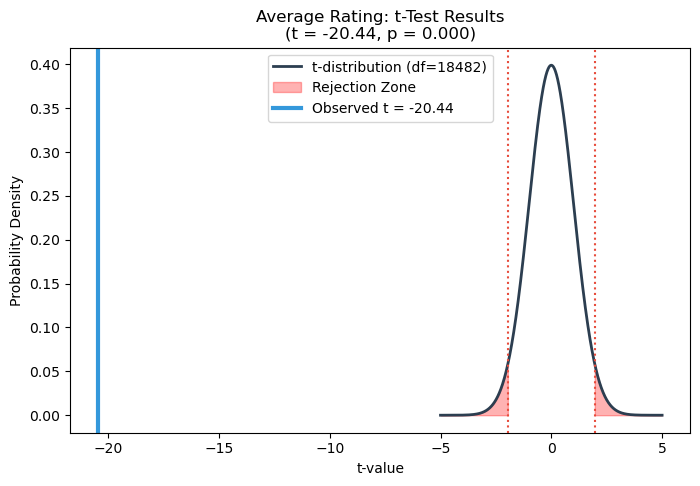

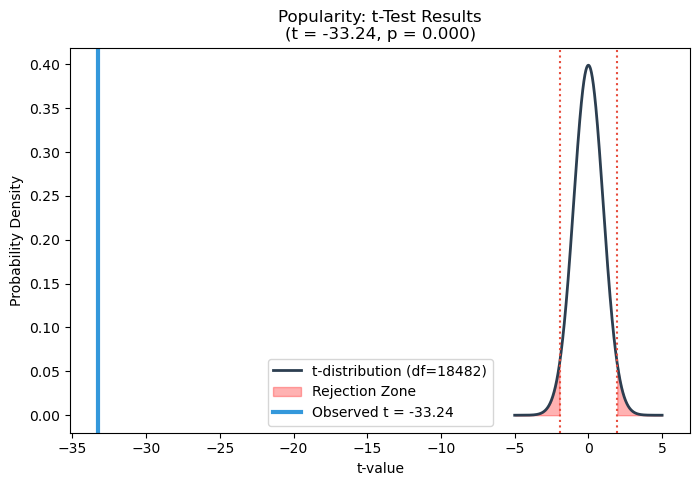

In [66]:
# Converting the T-test results into a dictionaries 
rating_results = {"t-statistic": ttest_rating.statistic, "p-value": ttest_rating.pvalue, "df": len(short_movies)+len(long_movies)-2}
popularity_results = {"t-statistic": ttest_popularity.statistic, "p-value": ttest_popularity.pvalue, "df": len(short_movies)+len(long_movies)-2}

# Critical t-value for alpha=0.05 (two-tailed)
alpha = 0.05

def plot_t_test(result, title):
    """
    This function Plots the t-distribution curve for a two-tailed independent t-test and highlights the 
    critical regions (rejection zones) along with the observed t-statistic.

    Parameters:
    -----------
    result : dict
        A dictionary containing:
        - 't-statistic': The computed t-statistic from the test.
        - 'p-value': The associated p-value.
        - 'df': Degrees of freedom from the test.
    """    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Generate t-distribution curve
    x = np.linspace(-5, 5, 1000)
    y = t.pdf(x, result["df"])
    
    # Plot the distribution
    ax.plot(x, y, color='#2c3e50', linewidth=2, 
            label=f"t-distribution (df={result['df']})")
    
    # Calculate critical values
    critical_lower = t.ppf(alpha/2, result["df"])
    critical_upper = t.ppf(1-alpha/2, result["df"])
    
    # Shade rejection regions
    x_fill_lower = np.linspace(-5, critical_lower, 100)
    x_fill_upper = np.linspace(critical_upper, 5, 100)
    ax.fill_between(x_fill_lower, t.pdf(x_fill_lower, result["df"]), 
                    color='red', alpha=0.3, label='Rejection Zone')
    ax.fill_between(x_fill_upper, t.pdf(x_fill_upper, result["df"]), 
                    color='red', alpha=0.3)
    
    # Critical value markers
    ax.axvline(critical_lower, color='#e74c3c', linestyle=':', linewidth=1.5)
    ax.axvline(critical_upper, color='#e74c3c', linestyle=':', linewidth=1.5)
    
    # Observed t-statistic
    ax.axvline(result["t-statistic"], color='#3498db', linewidth=3, 
              label=f'Observed t = {result["t-statistic"]:.2f}')
    
    # Annotations
    plt.title(f"{title}\n(t = {result['t-statistic']:.2f}, p = {result['p-value']:.3f})")
    plt.xlabel("t-value")
    plt.ylabel("Probability Density")
    ax.legend()
    # plt.grid(True, alpha=0.3)
    plt.show()
   

# Generating the plots
plot_t_test(rating_results, "Average Rating: t-Test Results")
plot_t_test(popularity_results, "Popularity: t-Test Results")

# Hypothesis testing

    a) For Popularity:
- For this one we have found that -1.969 < t > 1.969. Therefore we fail reject the NULL hypothesis
    Null Hypothesis (H₀): Runtime has no effect on popularity. (H₀: μ₁ = μ₂)
    Because Runtime has an effect on popularity. (H₁: μ₁ ≠ μ₂)

b) For Average Rating:
- For this one we found that -1.969 < t > 1.969, therefore we fail to reject the NULL hypothesis (H₀: μ₁ = μ₂)
    Because Runtime has an effect on popularity. (H₁: μ₁ ≠ μ₂)



# Observations
- The t-values were very large when compared to the t-critical -1.969 < t > 1.969 which hinted that runtime has an effect on both popularity and average ratings. Such observed differences are highly improbable if H₀ were true.

- From our Correlation and our pvalues we have seen that there is an effect of runtime on popularity and average ratings but from our Cohen d we see that the effect size of it is very small only *(0.2)*. 
This implies that that there are other factors that are more important that largely contribute to popularity and ratings.

## Recommendations

- Because shortening or extending a film’s duration is unlikely to substantially alter its reception. Filmmakers should prioritize other creative or marketing factors to maximize success and improve ratings and popularity.
